In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Enable mixed precision for RTX GPUs
mixed_precision.set_global_policy("mixed_float16")


TensorFlow version: 2.10.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2050, compute capability 8.6


In [2]:
BASE_DIR = "../data"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
CSV_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")

IMG_SIZE = 256
BATCH_SIZE = 12
EPOCHS_STAGE_1 = 30
EPOCHS_STAGE_2 = 30
EPOCHS_STAGE_3 = 20
NUM_CLASSES = 7


In [3]:
df = pd.read_csv(CSV_PATH)

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['label'] = df['dx'].map(lesion_type_dict)
df['label_idx'] = pd.Categorical(df['label']).codes
df['path'] = df['image_id'].apply(lambda x: os.path.join(IMAGE_DIR, x + ".jpg"))
df['age'] = df['age'].fillna(df['age'].mean())

print("Class distribution:")
print(df['label'].value_counts())


Class distribution:
label
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['path'],
    df['label_idx'],
    test_size=0.2,
    stratify=df['label_idx'],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 8012, Val: 1001, Test: 1002


In [5]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 4.368593238822246, 1: 2.7848453249913105, 2: 1.3021290427433772, 3: 12.440993788819876, 4: 0.21338020666879728, 5: 1.2860353130016051, 6: 10.040100250626567}


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)

    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)

    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_hue(img, 0.1)

    if tf.random.uniform([]) > 0.5:
        scale = tf.random.uniform([], 0.8, 1.0)
        new_size = tf.cast(IMG_SIZE * scale, tf.int32)
        img = tf.image.resize(img, (new_size, new_size))
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)

    img = tf.clip_by_value(img, 0, 255)
    return img, label


In [7]:
def load_image(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    if augment:
        img, label = augment_image(img, label)

    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img, label


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_ds = train_ds.shuffle(2048).map(
    lambda x, y: load_image(x, y, True),
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_ds = val_ds.map(
    lambda x, y: load_image(x, y, False),
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_ds = test_ds.map(
    lambda x, y: load_image(x, y, False),
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE)


In [9]:
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

base_model = EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = Model(base_model.input, outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 40  1080        ['normalization[0][0]']      

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [11]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_1,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5),
        ModelCheckpoint("best_model_stage1.keras", save_best_only=True)
    ]
)


Epoch 1/30
668/668 [==============================] - 229s 310ms/step - loss: 16.2621 - accuracy: 0.3213 - val_loss: 11.0052 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 2/30
668/668 [==============================] - 225s 337ms/step - loss: 8.7360 - accuracy: 0.3612 - val_loss: 6.6059 - val_accuracy: 0.3057 - lr: 0.0010
Epoch 3/30
668/668 [==============================] - 220s 329ms/step - loss: 5.7516 - accuracy: 0.3658 - val_loss: 4.9823 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 4/30
668/668 [==============================] - 330s 494ms/step - loss: 5.0360 - accuracy: 0.3753 - val_loss: 4.7024 - val_accuracy: 0.3536 - lr: 0.0010
Epoch 5/30
668/668 [==============================] - 244s 363ms/step - loss: 4.9432 - accuracy: 0.3794 - val_loss: 4.5346 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 6/30
668/668 [==============================] - 196s 293ms/step - loss: 4.7868 - accuracy: 0.3822 - val_loss: 4.6778 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 7/30
668/668 [========================

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_2,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=12, restore_best_weights=True),
        ReduceLROnPlateau(patience=6),
        ModelCheckpoint("best_model_stage2.keras", save_best_only=True)
    ]
)


Epoch 1/30
668/668 [==============================] - 461s 639ms/step - loss: 1.9566 - accuracy: 0.4803 - val_loss: 1.8175 - val_accuracy: 0.5105 - lr: 1.0000e-04
Epoch 2/30
668/668 [==============================] - 235s 351ms/step - loss: 1.7878 - accuracy: 0.5041 - val_loss: 1.9186 - val_accuracy: 0.4705 - lr: 1.0000e-04
Epoch 3/30
668/668 [==============================] - 218s 326ms/step - loss: 1.6927 - accuracy: 0.5156 - val_loss: 1.6612 - val_accuracy: 0.5694 - lr: 1.0000e-04
Epoch 4/30
668/668 [==============================] - 217s 325ms/step - loss: 1.5951 - accuracy: 0.5399 - val_loss: 1.5467 - val_accuracy: 0.5824 - lr: 1.0000e-04
Epoch 5/30
668/668 [==============================] - 216s 323ms/step - loss: 1.5049 - accuracy: 0.5438 - val_loss: 1.6547 - val_accuracy: 0.5634 - lr: 1.0000e-04
Epoch 6/30
668/668 [==============================] - 215s 322ms/step - loss: 1.4298 - accuracy: 0.5745 - val_loss: 1.5918 - val_accuracy: 0.5974 - lr: 1.0000e-04
Epoch 7/30
668/668 [==

In [13]:
for layer in base_model.layers[-150:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(5e-6),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_3,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(patience=7),
        ModelCheckpoint("best_model_final.keras", save_best_only=True)
    ]
)


Epoch 1/20
668/668 [==============================] - 265s 364ms/step - loss: 0.9134 - accuracy: 0.6877 - val_loss: 1.1495 - val_accuracy: 0.6923 - lr: 5.0000e-06
Epoch 2/20
668/668 [==============================] - 228s 341ms/step - loss: 0.9137 - accuracy: 0.6845 - val_loss: 1.1983 - val_accuracy: 0.6753 - lr: 5.0000e-06
Epoch 3/20
668/668 [==============================] - 228s 340ms/step - loss: 0.8799 - accuracy: 0.6858 - val_loss: 1.2332 - val_accuracy: 0.6603 - lr: 5.0000e-06
Epoch 4/20
668/668 [==============================] - 227s 340ms/step - loss: 0.8827 - accuracy: 0.6875 - val_loss: 1.1753 - val_accuracy: 0.6773 - lr: 5.0000e-06
Epoch 5/20
668/668 [==============================] - 229s 343ms/step - loss: 0.8598 - accuracy: 0.6902 - val_loss: 1.0767 - val_accuracy: 0.7153 - lr: 5.0000e-06
Epoch 6/20
668/668 [==============================] - 225s 336ms/step - loss: 0.8131 - accuracy: 0.6978 - val_loss: 1.1569 - val_accuracy: 0.6913 - lr: 5.0000e-06
Epoch 7/20
668/668 [==

In [14]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(
    y_test,
    y_pred,
    target_names=lesion_type_dict.values()
))


84/84 [==============================] - 21s 250ms/step - loss: 1.0970 - accuracy: 0.7006
Test Accuracy: 70.06%
84/84 [==============================] - 25s 254ms/step
                               precision    recall  f1-score   support

             Melanocytic nevi       0.41      0.69      0.51        32
                     Melanoma       0.52      0.90      0.66        52
Benign keratosis-like lesions       0.51      0.69      0.59       110
         Basal cell carcinoma       0.18      0.55      0.27        11
            Actinic keratoses       0.96      0.69      0.80       671
             Vascular lesions       0.43      0.64      0.52       112
               Dermatofibroma       0.54      0.93      0.68        14

                     accuracy                           0.70      1002
                    macro avg       0.51      0.73      0.58      1002
                 weighted avg       0.80      0.70      0.72      1002



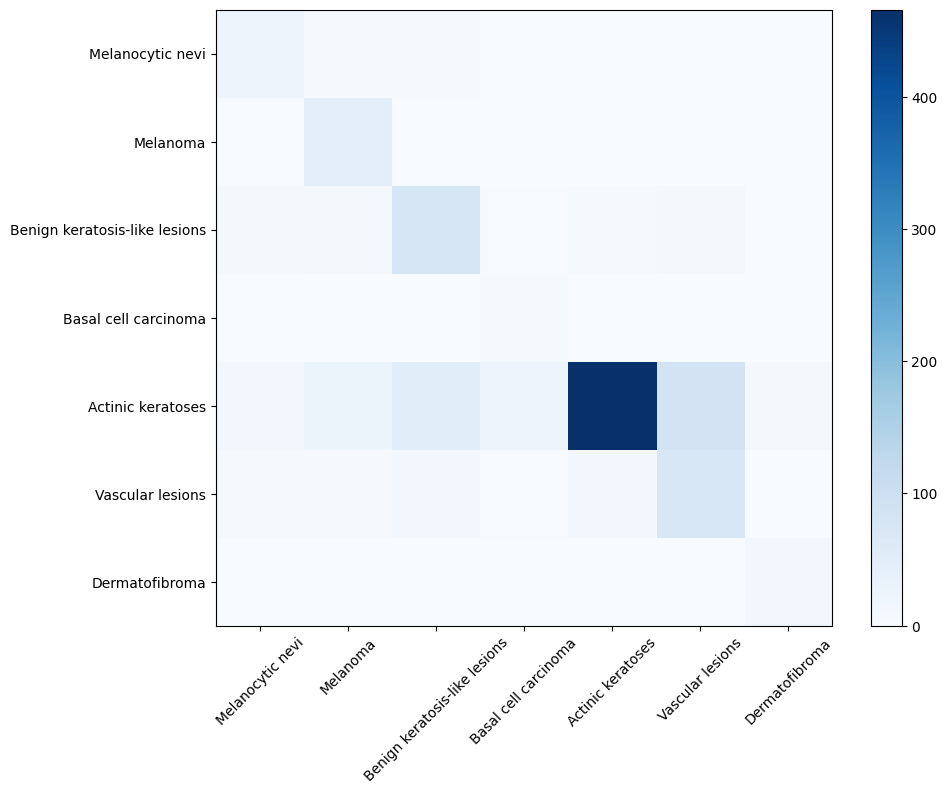

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.xticks(range(NUM_CLASSES), lesion_type_dict.values(), rotation=45)
plt.yticks(range(NUM_CLASSES), lesion_type_dict.values())
plt.colorbar()
plt.show()


In [16]:
os.makedirs("../models", exist_ok=True)
model.save("../models/skin_efficientnet_v2_final_90plus.h5")
print("✅ Model saved successfully")


✅ Model saved successfully
